In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [26]:
import pandas as pd
import numpy as np

In [133]:
data_path = "/content/drive/My Drive/CombinedFinal.csv"
df = pd.read_csv(data_path)

pd.set_option('display.max_columns',1000)
pd.set_option('display.width',10000)
print(df)

            Date     Open     High      Low    Close   GDP USD   GDP CAD  Interest Rate USD  Interest Rate CAD  CPI USD  CPI CAD  GDP USD_Lag_1  GDP USD_Lag_2  GDP USD_Lag_3  GDP CAD_Lag_1  GDP CAD_Lag_2  GDP CAD_Lag_3  Interest Rate USD_Lag_1  Interest Rate USD_Lag_2  Interest Rate USD_Lag_3  Interest Rate CAD_Lag_1  Interest Rate CAD_Lag_2  Interest Rate CAD_Lag_3  CPI USD_Lag_1  CPI USD_Lag_2  CPI USD_Lag_3  CPI CAD_Lag_1  CPI CAD_Lag_2  CPI CAD_Lag_3  Sentiment Score  sentiment_weighted_lag_1  sentiment_weighted_lag_2  sentiment_weighted_lag_3
0     2016-01-03  1.38737  1.39400  1.38480  1.38645  0.579519  0.591684               0.34               0.50  237.652    126.8       0.579519       0.579519       0.579519       0.591684       0.591684       0.591684                     0.34                     0.34                     0.34                     0.50                      0.5                      0.5        237.652        237.652        237.652          126.8          126.8   

In [134]:
from ctypes import DEFAULT_MODE
# preprocess data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# df['Interest Rate CAD'] = df['Interest Rate CAD'].str.strip()
# df.loc[df['Interest Rate CAD'] == 'Bank Holiday', 'Interest Rate CAD'] = None


# df['Interest Rate CAD'] = pd.to_numeric(df['Interest Rate CAD'], errors='coerce')
# df['Interest Rate CAD'] = df['Interest Rate CAD'].fillna(method='ffill')


print(df)

# price_columns = ['Open', 'High', 'Low', 'Close']
price_columns = ['Close']

economic_indicators = ['GDP USD', 'GDP CAD', 'Interest Rate USD', 'Interest Rate CAD',
                       'CPI USD', 'CPI CAD', 'GDP USD_Lag_1', 'GDP USD_Lag_2', 'GDP USD_Lag_3',
                       'GDP CAD_Lag_1', 'GDP CAD_Lag_2', 'GDP CAD_Lag_3',
                       'Interest Rate USD_Lag_1', 'Interest Rate USD_Lag_2', 'Interest Rate USD_Lag_1',
                       'Interest Rate CAD_Lag_1', 'Interest Rate CAD_Lag_2', 'Interest Rate CAD_Lag_3',
                       'CPI USD_Lag_1', 'CPI USD_Lag_2', 'CPI USD_Lag_3',
                       'CPI CAD_Lag_1', 'CPI CAD_Lag_2', 'CPI CAD_Lag_3']

sentiment_columns = ['Sentiment Score', 'sentiment_weighted_lag_1',
                     'sentiment_weighted_lag_2', 'sentiment_weighted_lag_3']

# Combine all columns to scale
standardize_columns = economic_indicators
minmax_columns = sentiment_columns

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler
df[standardize_columns] = standard_scaler.fit_transform(df[standardize_columns])

# Apply MinMaxScaler
df[minmax_columns] = minmax_scaler.fit_transform(df[minmax_columns])

print(df)

            Date     Open     High      Low    Close   GDP USD   GDP CAD  Interest Rate USD  Interest Rate CAD  CPI USD  CPI CAD  GDP USD_Lag_1  GDP USD_Lag_2  GDP USD_Lag_3  GDP CAD_Lag_1  GDP CAD_Lag_2  GDP CAD_Lag_3  Interest Rate USD_Lag_1  Interest Rate USD_Lag_2  Interest Rate USD_Lag_3  Interest Rate CAD_Lag_1  Interest Rate CAD_Lag_2  Interest Rate CAD_Lag_3  CPI USD_Lag_1  CPI USD_Lag_2  CPI USD_Lag_3  CPI CAD_Lag_1  CPI CAD_Lag_2  CPI CAD_Lag_3  Sentiment Score  sentiment_weighted_lag_1  sentiment_weighted_lag_2  sentiment_weighted_lag_3
0     2016-01-03  1.38737  1.39400  1.38480  1.38645  0.579519  0.591684               0.34               0.50  237.652    126.8       0.579519       0.579519       0.579519       0.591684       0.591684       0.591684                     0.34                     0.34                     0.34                     0.50                      0.5                      0.5        237.652        237.652        237.652          126.8          126.8   

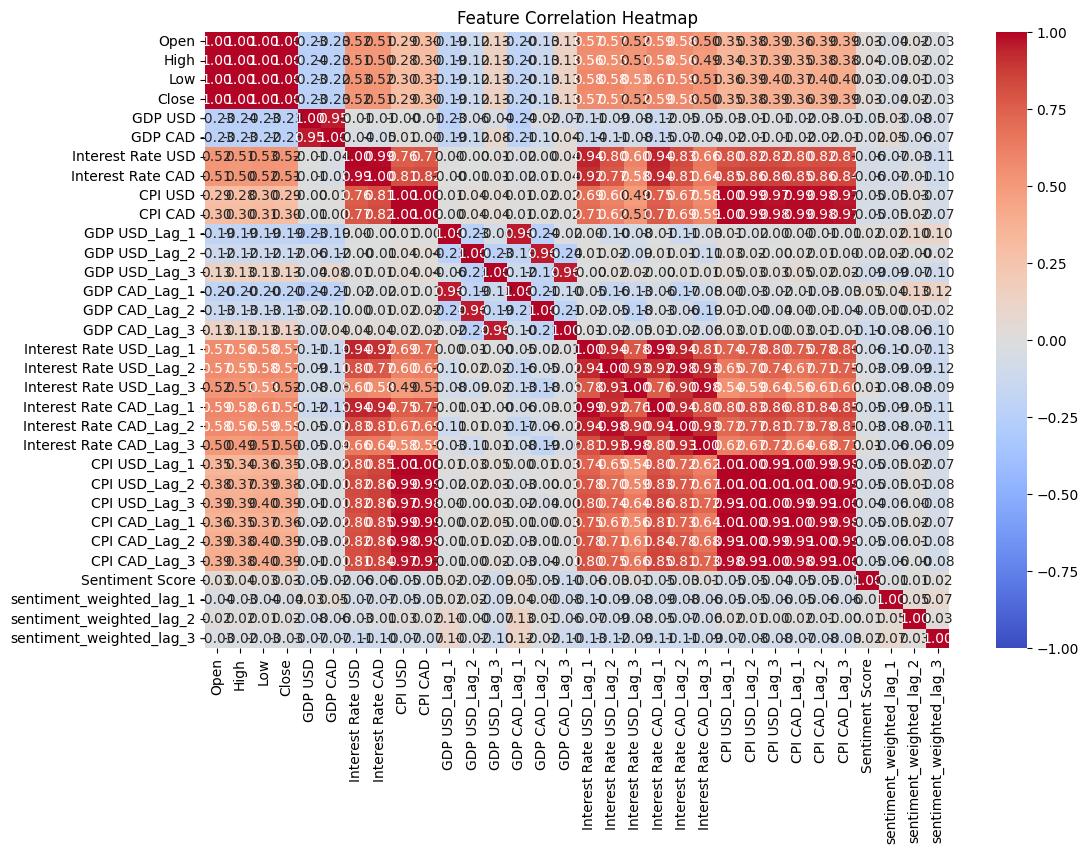

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.drop(columns=['Date']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [135]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Date', 'Close', 'Open', 'High','Low'])  # Drop non-numeric and target column
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 1854, Testing samples: 464


In [128]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

# Initialize the XGBoost model with parameters
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'  # Ensure the regression objective is used
)

# Train the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Validation dataset
    verbose=False                 # Set to False to suppress training logs
)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

y_pred = target_scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))
y_test = target_scaler.inverse_transform(y_test)
 # Reshaping for inverse transform


# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_xgb)

print(f"XGBoost Mean Squared Error: {mse_xgb}")
print(f"XGBoost Root Mean Squared Error: {rmse}")


XGBoost Mean Squared Error: 4.5624938772206546e-05
XGBoost Root Mean Squared Error: 0.006754623510767018


In [99]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Baseline Models
# Naive Model (random walk)
y_true = y_test[1:].flatten() # Fill y_pred_mean with the mean value of y_train and then flatten to 1D y_pred_mean = np.full_like(y_test[1:], np.mean(y_train)).flatten()
y_pred_mean = np.full_like(y_test[1:], np.mean(y_train)).flatten()
y_pred_naive = np.full_like(y_test[1:], np.mean(y_train)).flatten()

mse_naive = mean_squared_error(y_true, y_pred_naive)

# Calculate MSE for the Mean Model
mse_mean = mean_squared_error(y_true, y_pred_mean)

# Moving Average Model (3-day moving average)
window_size = 3
y_pred_ma_test = np.array([ np.mean(y_train[max(0, len(y_train) - window_size + i):len(y_train) + i]) for i in range(len(y_test) - 1) ])
# mse_ma = mean_squared_error(y_true, y_pred_ma_test)

# Your Model (assuming 'y_pred' is the output from your model)
mse_model = mean_squared_error(y_test, y_pred)

# Print out the results
print(f"MSE of Naive Model: {mse_naive}")
print(f"MSE of Mean Model: {mse_mean}")
# print(f"MSE of Moving Average Model: {mse_ma}")
print(f"MSE of Your Model: {mse_model}")


MSE of Naive Model: 1.7250316889190105
MSE of Mean Model: 1.7250316889190105
MSE of Your Model: 4.5624938772206546e-05


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [132]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Define the number of time steps (lags)
timesteps = 3

# Assuming X_train and X_test are already defined
# Reshape data for LSTM
X_train_lstm = np.array([X_train[i:i+timesteps] for i in range(len(X_train) - timesteps)])
y_train_lstm = y_train[timesteps:].values

X_test_lstm = np.array([X_test[i:i+timesteps] for i in range(len(X_test) - timesteps)])
y_test_lstm = y_test[timesteps:].values

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(timesteps, X_train.shape[1])),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)

# Get predictions from the LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Assuming standard_scaler is already fitted to the training data
standard_scaler = StandardScaler()
standard_scaler.fit(y_train.values.reshape(-1, 1))

# If you scaled the target variable, inverse-transform both y_test_lstm and y_pred_lstm
y_test_unscaled = standard_scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
y_pred_unscaled = standard_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

print(f"LSTM Mean Absolute Error: {mae}")
print(f"LSTM Root Mean Squared Error: {rmse}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5542
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0273
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 16/50
58/58 ━━━━━━━━━━━━

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import datetime

# Assuming X_train, X_test, y_train, and y_test are already defined and properly scaled

# Define parameters
num_steps = 10  # Look back at the last 10 days
num_features = 28  # Number of input features (e.g., GDP, CPI, sentiment, etc.)
num_outputs = 30  # Predict the next 30 days

# Reshape X_train and X_test to match the expected input shape for LSTM
X_train_lstm = np.array([X_train[i:i+num_steps] for i in range(len(X_train) - num_steps - num_outputs + 1)])
X_test_lstm = np.array([X_test[i:i+num_steps] for i in range(len(X_test) - num_steps - num_outputs + 1)])

# Ensure y_train and y_test are reshaped to match the output
y_train_lstm = np.array([y_train[i+num_steps:i+num_steps+num_outputs] for i in range(len(y_train) - num_steps - num_outputs + 1)])
y_test_lstm = np.array([y_test[i+num_steps:i+num_steps+num_outputs] for i in range(len(y_test) - num_steps - num_outputs + 1)])

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(num_steps, num_features)),
    Dense(num_outputs)  # Output layer predicts the next 30 days
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)

# Predict the next 30 days
forecast = model.predict(X_test_lstm)  # Shape: (num_samples, 30)
y_test_lstm = y_test_lstm[:len(forecast)]  # Ensure both have shape (num_samples, 30)

# Evaluate the forecasted values
mae_30 = mean_absolute_error(y_test_lstm, forecast)
mse_30 = mean_squared_error(y_test_lstm, forecast)
rmse_30 = np.sqrt(mse_30)

# Extract specific intervals
next_3_days = forecast[:, :3]
y_test_3 = y_test_lstm[:, :3]
mae_3 = mean_absolute_error(y_test_3, next_3_days)
mse_3 = mean_squared_error(y_test_3, next_3_days)
rmse_3 = np.sqrt(mse_3)

next_7_days = forecast[:, :7]
y_test_7 = y_test_lstm[:, :7]
mae_7 = mean_absolute_error(y_test_7, next_7_days)
mse_7 = mean_squared_error(y_test_7, next_7_days)
rmse_7 = np.sqrt(mse_7)

# Print results
print("Metrics for 3-day forecast:")
print(f"MAE: {mae_3}, MSE: {mse_3}, RMSE: {rmse_3}")

print("\nMetrics for 7-day forecast:")
print(f"MAE: {mae_7}, MSE: {mse_7}, RMSE: {rmse_7}")

print("\nMetrics for 30-day forecast:")
print(f"MAE: {mae_30}, MSE: {mse_30}, RMSE: {rmse_30}")

# # If you want to save it to a CSV file
# df_forecast.to_csv('forecast_vs_actual.csv', index=False)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 50)                  │          15,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 30)                  │           1,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,330 (67.70 KB)

 Trainable params: 17,330 (67.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.2238
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0499
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0188
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0114
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0082
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 16/50
57/

In [141]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming forecast and y_test_lstm are already defined from the previous code
# Also assuming test_dates is a list of dates corresponding to your test set

# Flatten the forecast and actual values for easier DataFrame construction
forecast_flat = forecast.flatten()
y_test_flat = y_test_lstm.flatten()

# Create a list of dates for the forecasted period
# Assuming the last date in your test set corresponds to the end date for the forecast
start_date = datetime.strptime("20241123", "%Y%m%d") # Parse the date from a string
forecast_dates = [start_date + timedelta(days=i) for i in range(len(forecast_flat))]

# Create the DataFrame
df_forecast = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_flat,
    'Actual': y_test_flat
})

# Print the DataFrame
print(df_forecast)


            Date  Forecast   Actual
0     2024-11-23  1.299414  1.24720
1     2024-11-24  1.322367  1.24985
2     2024-11-25  1.291690  1.35254
3     2024-11-26  1.304658  1.38766
4     2024-11-27  1.310811  1.33256
...          ...       ...      ...
12745 2059-10-16  1.317974  1.29088
12746 2059-10-17  1.294956  1.36152
12747 2059-10-18  1.327592  1.26620
12748 2059-10-19  1.306510  1.24422
12749 2059-10-20  1.312764  1.24667

[12750 rows x 3 columns]


In [ ]:

# Number of days to predict
num_days_to_predict = 3  # Adjust for your desired interval

# Start with the most recent input data
current_input = X_test[-1].reshape(1, -1)

# Placeholder for predictions
predictions = []

for _ in range(num_days_to_predict):
    # Predict the next step
    next_prediction = xgb_model.predict(current_input)

    # If scaled, inverse-transform the prediction
    next_prediction_unscaled = standard_scaler.inverse_transform(next_prediction.reshape(-1, 1)).flatten()[0]
    predictions.append(next_prediction_unscaled)

    # Update the input features by shifting and appending the new prediction
    # Assume the last column is the target variable (Close price)
    new_input = np.append(current_input[:, 1:], next_prediction, axis=1)  # Drop the oldest feature, add the new prediction
    current_input = new_input.reshape(1, -1)

# Create a DataFrame to display predictions
future_dates = pd.date_range(start='2024-11-24', periods=num_days_to_predict, freq='D')  # Adjust start date
predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': predictions})

print(predictions_df)


In [110]:
# Number of days to forecast
num_days_to_predict = 30

# Initialize the input with the last sequence from your test set
current_input = X_test_lstm[-1].reshape(1, *X_test_lstm[-1].shape)  # Shape: (1, timesteps, features)

# Store predictions
predictions = []

for _ in range(num_days_to_predict):
    # Predict the next step (single target variable, e.g., closing price)
    next_prediction = lstm_model.predict(current_input)  # Shape: (1, 1)

    # If scaled, inverse-transform the prediction
    next_prediction_unscaled = standard_scaler.inverse_transform(next_prediction).flatten()[0]
    predictions.append(next_prediction_unscaled)

    # Prepare the next input
    next_input = current_input[:, 1:, :]  # Drop the oldest timestep (keep all features)

    # Repeat the prediction across the feature dimension
    # Assume only the closing price changes; other features remain constant (last known values)
    new_feature_vector = np.copy(next_input[:, -1, :])  # Copy the most recent feature vector
    new_feature_vector[:, -1] = next_prediction  # Replace the target variable (e.g., closing price)

    # Reshape and append the new feature vector
    next_feature_vector = new_feature_vector.reshape(1, 1, -1)
    current_input = np.concatenate([next_input, next_feature_vector], axis=1)  # Append along the timestep axis



# Convert predictions to a DataFrame
future_dates = pd.date_range(start='2024-11-24', periods=num_days_to_predict, freq='D')  # Adjust start date
predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': predictions})

print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━

In [111]:
save_dir = '/content/drive/My Drive/thirty_day_prediction.csv'
predictions_df.to_csv(save_dir, index=False)